# CaH lin||lin Sisyphus data calcultion

In [1]:
import scipy
import pickle
import time
import pprint
import numpy as np
from tqdm import tqdm
import multiprocessing
from sympy import Symbol, sin, cos, tan, nsimplify
from sympy import MutableDenseMatrix, conjugate, Function, Symbol, diff, simplify, lambdify
import matplotlib.pyplot as plt
from utils.plot_utils import set_fontsize
from optical_bloch_test.utils.general import flatten
from optical_bloch_test import Hamiltonian, Dissipator, BlochEquations
from multi_helper_funcs import multi_solve_ode, multi_solve_ode_integrate_excited

In [2]:
hbar=1.054*1E-34; #[Js]
k_b=1.381*1E-23; #[J/K]
c=299792000; #[m/s]
eps_0=8.854*1E-12; #[F/m]
a0=5.29*1E-11; #[m]
q_e=1.602*1E-19; #[C]
Bohr_mag=1.39962449/1000*2*np.pi; #[GHz/G]
m_CaH = 6.8215E-26

ν = 431.27*1E12
Gamma = 1/(33E-9)

Re = np.sqrt(1/q_e**2 * 3*np.pi*eps_0*hbar*c**3/(2*np.pi*ν)**3 * Gamma)
print('for A state Re is',Re/a0, Re)
print(Re * q_e / (3.33564E-30))
print(Re * q_e / hbar / 1E9)

# ν = 472.03E12
# Gamma = 1/(58E-9)

# Re = np.sqrt(1/q_e**2 * 3*np.pi*eps_0*hbar*c**3/(2*np.pi*ν)**3 * Gamma)
# print('for B state Re is',Re/a0, Re)
# print(Re * q_e / (3.33564E-30))

for A state Re is 2.241748344258233 1.1858848741126051e-10
5.695421473325639
0.00018024549984140356


## Please note: time should be ns, frequency should be 2Pi GHz

In [3]:
nground = 12
nexcite = 4
ntotal = 16

In [4]:
rabi_matrix = np.zeros([ntotal,ntotal,3])
rabi_matrix[:,:,0] = np.genfromtxt('rabimatrixXA1.csv',delimiter=',')
rabi_matrix[:,:,1] = np.genfromtxt('rabimatrixXA2.csv',delimiter=',')
rabi_matrix[:,:,2] = np.genfromtxt('rabimatrixXA3.csv',delimiter=',')

In [5]:
E0 = Symbol(u'E0', real = True)
Ee = Symbol(u'Ee', real = True)
HFS12 = Symbol(u'HFS12', real = True)
HFS32 = Symbol(u'HFS32', real = True)
SR = Symbol(u'SR', real = True)
HFSB = Symbol(u'HFSB', real = True)

ω1 = Symbol(u'ω1', real = True)
ω2 = Symbol(u'ω2', real = True)
ω3 = Symbol(u'ω3', real = True)
ω4 = Symbol(u'ω4', real = True)
Ω1 = Symbol(u'Ω1', real = True)
Ω2 = Symbol(u'Ω2', real = True)
Ω3 = Symbol(u'Ω3', real = True)
Ω4 = Symbol(u'Ω4', real = True)
Δ1 = Symbol(u'Δ1', real = True)
Δ2 = Symbol(u'Δ2', real = True)
Δ3 = Symbol(u'Δ3', real = True)
Δ4 = Symbol(u'Δ4', real = True)


g_x12F1 = Symbol(u'g_x12F1', real = True)
g_x32F1 = Symbol(u'g_x32F1', real = True)
g_x32F2 = Symbol(u'g_x32F2', real = True)

θ = Symbol(u'θ', real = True)
B = Symbol(u'B', real = True)
k = Symbol(u'k', real = True)
v = Symbol(u'v', real = True)
t = Symbol(u't', real = True)
x = v*t

In [6]:
# States are added in following order:
# XSigma %1-4 - J=1/2, F=0, m=0;  F=1, m=-1,0,1 ;
# XSigma %5-7 - J=3/2, F=1, m=-1,0,1;
# XSigma %8-12 - J=3/2, F=2, m=-2,-1,0,1,2;
# BSigma %13-16 - J=1/2, F=0, m=0;  F=1, m=-1,0,1

ham = Hamiltonian(ntotal)
ham.addEnergies([E0,E0-HFS12-g_x12F1*B,E0-HFS12,E0-HFS12+g_x12F1*B,
                 E0+SR-g_x32F1*B,E0+SR,E0+SR+g_x32F1*B,
                 E0+SR+HFS32-2*g_x32F2*B,E0+SR+HFS32-g_x32F2*B,E0+SR+HFS32,E0+SR+HFS32+g_x32F2*B,E0+SR+HFS32+2*g_x32F2*B,
                 Ee,Ee+HFSB,Ee+HFSB,Ee+HFSB])

In [7]:
# θ = 30/180*np.pi
for i in [0]: #J=1/2, F=0 is θ+90
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)**(-1)*np.sqrt(2)*sin(θ+np.pi/2)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω1*rabi_matrix[i,j,0], ω1)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (-1)**(0)*2*cos(θ+np.pi/2)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω1*rabi_matrix[i,j,1], ω1)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = -(-1)**(1)*np.sqrt(2)*sin(θ+np.pi/2)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω1*rabi_matrix[i,j,2], ω1)
            
for i in [1,2,3]:#J=1/2, F=1 is θ
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)**(-1)*np.sqrt(2)*sin(θ)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω2*rabi_matrix[i,j,0], ω2)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (-1)**(0)*2*cos(θ)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω2*rabi_matrix[i,j,1], ω2)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = -(-1)**(1)*np.sqrt(2)*sin(θ)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω2*rabi_matrix[i,j,2], ω2)
            
for i in [4,5,6]: #J=3/2, F=1 is θ+90
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)**(-1)*np.sqrt(2)*sin(θ+np.pi/2)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω3*rabi_matrix[i,j,0], ω3)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (-1)**(0)*2*cos(θ+np.pi/2)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω3*rabi_matrix[i,j,1], ω3)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = -(-1)**(1)*np.sqrt(2)*sin(θ+np.pi/2)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω3*rabi_matrix[i,j,2], ω3)
            
for i in [7,8,9,10,11]: #J=3/2, F=2 is θ
    for j in range(nground, ntotal):
        if rabi_matrix[i, j, 0] != 0:
            prefactor = (-1)**(-1)*np.sqrt(2)*sin(θ)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω4*rabi_matrix[i,j,0], ω4)
        if rabi_matrix[i, j, 1] != 0:
            prefactor = (-1)**(0)*2*cos(θ)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω4*rabi_matrix[i,j,1], ω4)
        if rabi_matrix[i, j, 2] != 0:
            prefactor = -(-1)**(1)*np.sqrt(2)*sin(θ)*cos(k*x)
            ham.addCoupling(i, j, prefactor*Ω4*rabi_matrix[i,j,2], ω4)

In [8]:
ham.eqnTransform()
ham.defineZero(Ee)
ham.defineEnergyDetuning(E0, Ee, Δ1, ω1)
ham.defineEnergyDetuning(E0-HFS12, Ee, Δ2, ω2)
ham.defineEnergyDetuning(E0+SR, Ee, Δ3, ω3)
ham.defineEnergyDetuning(E0+SR+HFS32, Ee, Δ4, ω4)
DH = simplify(diff(ham.transformed,t)/v)

In [9]:
ham.transformed

Matrix([
[                                                  -1.0*Δ1,                                       0,                                       0,                                       0,                                                         0,                                                         0,                                                         0,                                      0,                                       0,                                       0,                                       0,                                       0,                                                         0, -0.333333333333334*Ω1*sin(θ + 1.5707963267949)*cos(k*t*v),  0.471404520791032*Ω1*cos(k*t*v)*cos(θ + 1.5707963267949),  0.333333333333334*Ω1*sin(θ + 1.5707963267949)*cos(k*t*v)],
[                                                        0,                     -B*g_x12F1 - 1.0*Δ2,                                       0,                                       0,        

In [10]:
transition_strengths=np.zeros([ntotal,ntotal]);
for i in range(ntotal):
    for f in range(ntotal):
        for p in range(3):
            transition_strengths[i,f]=transition_strengths[i,f]+rabi_matrix[i,f,p]**2

In [11]:
BR = np.zeros([ntotal, ntotal])
for i in range(ntotal):
    sums=0
    for f in range(ntotal):
        sums=sums+transition_strengths[i,f]
        
    for f in range(ntotal):
        BR[i,f]=transition_strengths[i,f]/sums
        
for i in range(nground):
    BR[i,:]=0
    

In [12]:
BR[nground:,:]

array([[0.        , 0.22222222, 0.22222222, 0.22222222, 0.11111111,
        0.11111111, 0.11111111, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.22222222, 0.22222222, 0.        , 0.02777778,
        0.02777778, 0.        , 0.16666667, 0.08333333, 0.02777778,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.22222222, 0.        , 0.22222222, 0.02777778,
        0.        , 0.02777778, 0.        , 0.08333333, 0.11111111,
        0.08333333, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.22222222, 0.        , 0.22222222, 0.22222222, 0.        ,
        0.02777778, 0.02777778, 0.        , 0.        , 0.02777778,
        0.08333333, 0.16666667, 0.        , 0.        , 0.        ,
        0.        ]])

In [13]:
Γ = Symbol(u'Γ', real = True)
dis = Dissipator(ntotal)

for exct in tqdm(range(nground, ntotal)):
    for grnd in range(nground):
        if BR[exct, grnd] != 0:
            dis.addDecay(exct, grnd, Γ * BR[exct, grnd])

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:22<00:00,  5.70s/it]


In [14]:
dis.dissipator

Matrix([
[Γ*(0.222222222222222*ρ₍₍(t) + 0.222222222222222*ρ₎₎(t) + 0.222222222222222*ρ₏₏(t)),                                                                                  0,                                                                                  0,                                                                                  0,                                                                                    0,                                                                                    0,                                                                                    0,                          0,                                                         0,                                                                                    0,                                                         0,                          0,            -0.5*Γ*ρ₀₌(t),            -0.5*Γ*ρ₀₍(t),            -0.5*Γ*ρ₀₎(t), -0.5*Γ*ρ₀₏(t)],
[                                         

In [15]:
%%time
bloch = BlochEquations(ntotal, dis.density_matrix, ham.transformed, dis.dissipator)

start generateEquations
Wall time: 6.04 s


In [16]:
y0 = np.zeros([ntotal, ntotal], dtype = complex)
for i in range(nground):
    y0[i,i] = 1/nground
y0 = y0.flatten()

# Use Julia

In [17]:
from julia import Main

nprocs = 4 # number of processes to use for EnsembleDistributed 
Main.eval(f"""
using BenchmarkTools
using Distributed
""")

if Main.eval("nprocs()") < nprocs:
    Main.eval(f"addprocs({nprocs}-nprocs())")

if Main.eval("nprocs()") > nprocs:
    addprocs({nprocs})
    procs = Main.eval("procs()")
    procs = procs[nprocs:]
    Main.eval(f"rmprocs({procs})")

Main.eval("""
@everywhere begin
    using ModelingToolkit
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    using ModelingToolkit
end
""")

    
Main.eval("procs()")

array([1, 2, 3, 4], dtype=int64)

In [18]:
hamiltonian_symbols = ham.transformed.free_symbols
hamiltonian_symbols = [d for d in hamiltonian_symbols if str(d)[0] not in ['t']]
dissipator_symbols = dis.dissipator.free_symbols
dissipator_symbols = [d for d in dissipator_symbols if str(d)[0] not in ['ρ', 't']]
                      
lx, ly = ham.transformed.shape
Main.eval(f"""
            @everywhere begin
            H = zeros(Num, {lx}, {ly})
            L = zeros(Num, {lx}, {ly})
            @variables t ρ[1:{lx},1:{ly}](t)
            @parameters icomplex
            D = Differential(t)
            tmp = 0
            end
            """);

for s in list(hamiltonian_symbols) + list(dissipator_symbols):
    Main.eval(f"""
                @everywhere @parameters {str(s)}
                tmp = 0
            """);

    

# the code below is to transform the symbolic version of Sympy into a form usable with Julia
diss = MutableDenseMatrix(dis.dissipator.copy())

for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(j+1, i+1))
        diss = diss.subs(conjugate(tmp(t)), tmp1(t))
            
for i in range(lx):
    for j in range(i,ly):
        tmp = Function(u'ρ{0}{1}'.format(chr(0x2080+i), 
                                         chr(0x2080+j)))
        tmp1 = Function(u'ρ[{0},{1}]'.format(i+1, j+1))
        diss = diss.subs(tmp(t), tmp1(t))


# Creating the Hamiltonian matrix and Dissipator matrix in Julia
for idx in range(1,lx+1):
    for idy in range(1,ly+1):
        hval = str(ham.transformed[idx-1,idy-1])
        hval = hval.replace('I','icomplex')
        print(hval)
        dval = str(diss[idx-1, idy-1])
        dval = dval.replace('(t)', '')
        Main.eval(f"""
                @everywhere begin
                H[{idx},{idy}] = {hval}
                L[{idx},{idy}] = {dval}
                tmp = 0
                end
                """);

-1.0*Δ1
0
0
0
0
0
0
0
0
0
0
0
0
-0.333333333333334*Ω1*sin(θ + 1.5707963267949)*cos(k*t*v)
0.471404520791032*Ω1*cos(k*t*v)*cos(θ + 1.5707963267949)
0.333333333333334*Ω1*sin(θ + 1.5707963267949)*cos(k*t*v)
0
-B*g_x12F1 - 1.0*Δ2
0
0
0
0
0
0
0
0
0
0
-0.333333333333334*Ω2*sin(θ)*cos(k*t*v)
-0.471404520791032*Ω2*cos(θ)*cos(k*t*v)
-0.333333333333334*Ω2*sin(θ)*cos(k*t*v)
0
0
0
-1.0*Δ2
0
0
0
0
0
0
0
0
0
0.471404520791032*Ω2*cos(θ)*cos(k*t*v)
-0.333333333333334*Ω2*sin(θ)*cos(k*t*v)
0
-0.333333333333334*Ω2*sin(θ)*cos(k*t*v)
0
0
0
B*g_x12F1 - 1.0*Δ2
0
0
0
0
0
0
0
0
0.333333333333334*Ω2*sin(θ)*cos(k*t*v)
0
-0.333333333333334*Ω2*sin(θ)*cos(k*t*v)
0.471404520791032*Ω2*cos(θ)*cos(k*t*v)
0
0
0
0
-B*g_x32F1 - 1.0*Δ3
0
0
0
0
0
0
0
0.235702260395516*Ω3*sin(θ + 1.5707963267949)*cos(k*t*v)
-0.166666666666667*Ω3*cos(k*t*v)*cos(θ + 1.5707963267949)
-0.117851130197758*Ω3*sin(θ + 1.5707963267949)*cos(k*t*v)
0
0
0
0
0
0
-1.0*Δ3
0
0
0
0
0
0
-0.333333333333333*Ω3*cos(k*t*v)*cos(θ + 1.5707963267949)
-0.117851130197

In [19]:
# Creating the system of equations
Main.eval(f"""
@everywhere begin
    eq = -icomplex*Symbolics.scalarize(H*ρ-ρ*H) + L
    eqns = [D(ρ[idx,idy]) ~ eq[idx,idy] for idx in 1:{lx} for idy in 1:{ly}];
    @named bloch = ODESystem(eqns)
    tmp = 0
end
""");
Main.eval("@everywhere bloch = structural_simplify(bloch)");

In [20]:
# initial populations
y0 = np.zeros([ham.levels, ham.levels], dtype = complex)
for _ in range(nground):
    y0[_,_] = 1/nground
Main.ρ_ini = y0
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [21]:
# constants setup
Main.eval("""
    @everywhere begin
    Bohr_mag=1.39962449/1000*2*pi
    c=299792000
    hbar=1.054E-34
    Γ_val = 1/33
    tmp =0;
end
""");

In [23]:
# Calculate rabi rate using Powers： Method 1
Main.eval("""
    @everywhere begin
    
    lambda_laser = 695E-9
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 30E-3
    Power_laser2 = 40E-3
    Power_laser3 = 48E-3
    Power_laser4 = 45E-3

    beam_dia = 4E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print(Main.Γ_val,Main.Ω1_val,Main.Ω2_val,Main.Ω3_val,Main.Ω4_val)

0.030303030303030304 0.24167201667195687 0.27905880776230807 0.30569360776382776 0.29598656297784176


In [24]:
print(hamiltonian_symbols,dissipator_symbols)

[g_x12F1, g_x32F1, Ω3, Δ4, B, Δ1, HFSB, θ, v, k, Δ2, Δ3, Ω4, Ω1, Ω2, g_x32F2] [Γ]


In [25]:
# setting up the parameters of the model and initial conditions
Main.eval("""
    @everywhere begin
    Δgroup = 10E-3*2*pi
    Γ_val = 1/33
    θset = 10/180*pi
    p = [
    θ => θset,
    B => 2.3,
    k => 2*pi/695,
    Δ1 => Δgroup,
    Δ2 => Δgroup,
    Δ3 => Δgroup,
    Δ4 => Δgroup,
    Ω1 => Ω1_val,
    Ω2 => Ω2_val,
    Ω3 => Ω3_val,
    Ω4 => Ω4_val,
    g_x12F1 => -0.33*Bohr_mag,
    g_x32F1 => 0.83*Bohr_mag,
    g_x32F2 => 0.5*Bohr_mag,
    Γ => Γ_val,
    HFSB => 0,
    v => 3,
    icomplex => im
    ]
    u0 = [ρ[idx,idy] => ρ_ini[idx,idy] for idx in 1:size(ρ_ini)[1] for idy in 1:size(ρ_ini)[1]]
    tmp =0;
end
""");

In [26]:
%%time
# creating the problem to solve
Main.eval("""
@everywhere begin
    tspan = (0., 2000.)
    prob = ODEProblem(bloch, ρ_ini, tspan, p, jac = true)
end
""");

Wall time: 42.5 s


Wall time: 19.8 s


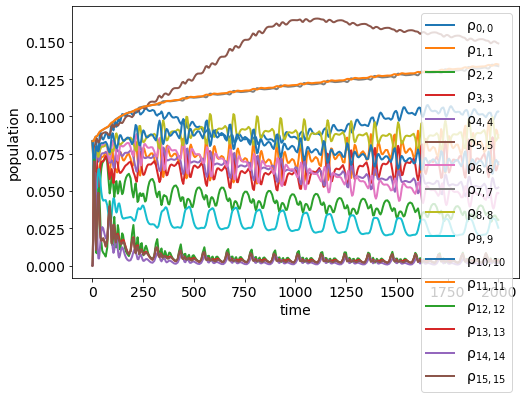

In [27]:
%%time
# solving the ODEProblem, keep in mind that the first run compiles called functions
# the first run will be significantly slower (due to compilation), but any subsequent solves are fast
Main.eval("@time sol = solve(prob, Tsit5())");
ut = np.array(Main.eval("sol[:]"))
dim = int(np.sqrt(ut.shape[1]))
pop_results = np.real(np.einsum('jji->ji',ut.reshape(-1,dim, dim).T))
t_array = Main.eval("sol.t")
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$")

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

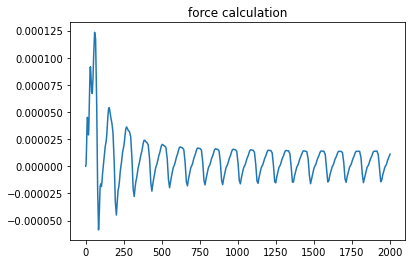

In [28]:
# fore calculation
DH_new = DH.subs([(k, 2*np.pi/695),(θ,Main.θset),(Ω1, Main.Ω1_val),(Ω2, Main.Ω2_val),(Ω3, Main.Ω3_val),(Ω4, Main.Ω4_val)])
f_func = lambdify((v,t), DH_new, modules='numpy')
force_list = []
ρt = ut.reshape(-1,ntotal, ntotal)
t_array = Main.eval("sol.t")

for t_ind in range(len(t_array)):
    dH = f_func(3,t_array[t_ind])
    f_temp = np.matmul(ρt[t_ind],dH)
    force = np.trace(np.real(f_temp))
    force_list.append(force)
    
plt.plot(t_array, force_list)
plt.title('force calculation')
plt.show()

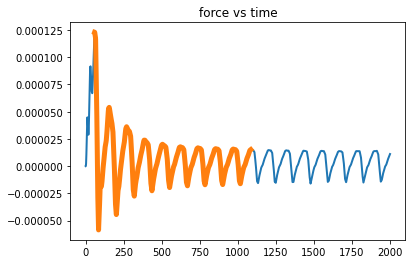

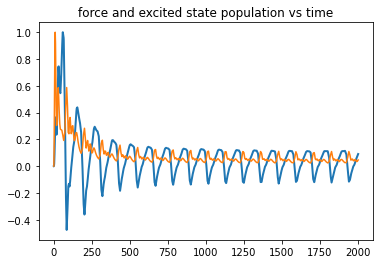

In [29]:
sample_size = 3000
t_max = t_array[-1]
t_interp = np.linspace(0,t_max,sample_size)
force_interp = np.interp(t_interp,t_array,force_list)
t_midind = int(sample_size/2)

max_sig_ind_in_1 = np.argmax(force_interp[0:t_midind])
max_sig_ind_in_2 = np.argmax(force_interp[t_midind:])+t_midind
plt.plot(t_interp,force_interp,lw=2)
plt.plot(t_interp[max_sig_ind_in_1:max_sig_ind_in_2],force_interp[max_sig_ind_in_1:max_sig_ind_in_2],lw=5)
force_int = np.mean(force_interp[max_sig_ind_in_1:max_sig_ind_in_2])
plt.title('force vs time')
plt.show()
plt.plot(t_interp,force_interp/np.max(np.abs(force_interp)),lw=2)
ex_pop = np.array([np.sum([np.real(ρt[_,__,__]) for __ in range(nground, ntotal)]) for _ in range(len(t_array))])
plt.plot(t_array, ex_pop/np.max(ex_pop))
plt.title('force and excited state population vs time')
plt.show()

# Define it as a function

In [30]:
def sweep_vel_get_force(varlist, Δ_input=10E-3*2*np.pi, B_input=2.3, θ_input=30/180*np.pi, SF_Ω=1, savedat=False):
    Main.params = varlist
    Main.eval("@everywhere params = $params")
    Main.eval(f"""
    @everywhere function prob_func(prob,i,repeat)
        Γ_val = 1/33
        Δgroup = {Δ_input}
        pnew = ModelingToolkit.varmap_to_vars([
            θ=> {θ_input},
            B => {B_input},
            k => 2*pi/695,
            Δ1 => Δgroup,
            Δ2 => Δgroup,
            Δ3 => Δgroup,
            Δ4 => Δgroup,
            Ω1 => Ω1_val*{SF_Ω},
            Ω2 => Ω2_val*{SF_Ω},
            Ω3 => Ω3_val*{SF_Ω},
            Ω4 => Ω4_val*{SF_Ω},
            g_x12F1 => -0.33*Bohr_mag,
            g_x32F1 => 0.83*Bohr_mag,
            g_x32F2 => 0.5*Bohr_mag,
            Γ => Γ_val,
            HFSB => 0E-3,
            v => params[i],
            icomplex => im
            ], parameters(bloch))
        tspan = (-50000., 3000/params[i])
       remake(prob, p = pnew, tspan = tspan)
    end
    """)
    Main.eval("""
    @everywhere function output_func(sol,i)
        ind = findmin(abs.(sol.t.-0.))[2]
        return [sol.t[ind:end],sol.u[ind:end]], false
    end
    """)
    Main.eval("ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func)");
    Main.eval("""
    @time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true,
                       save_everystep = true; trajectories = size(params)[1], adaptive=true,reltol =1e-6)
    sim.elapsedTime
    """)
    all_results = Main.eval("""sim.u""")

    prefactor = 1/m_CaH*hbar*1E18
    DH_new = prefactor*DH.subs([(k, 2*np.pi/695),(θ,θ_input),(Ω1, Main.Ω1_val*SF_Ω),
                                (Ω2, Main.Ω2_val*SF_Ω),(Ω3, Main.Ω3_val*SF_Ω),(Ω4, Main.Ω4_val*SF_Ω)])
    δH = lambdify((v,t), DH_new, modules='numpy')
    force_allvar = []
    pltdim = int(np.sqrt(len(varlist))+1)
#     fig = plt.figure(figsize = (15,15))

    for ind in tqdm(range(len(varlist))):
        t_array = all_results[ind][0]
        ρt = np.array(all_results[ind][1]).reshape(-1,ntotal,ntotal)
        ex_pop = np.array([np.sum([np.real(ρt[_,__,__]) for __ in range(nground,ntotal)]) for _ in range(len(t_array))])
        force_list = []
        for t_ind in range(len(t_array)):
            dH = δH(varlist[ind],t_array[t_ind])
            f_temp = -np.matmul(ρt[t_ind],dH)
            force = np.trace(np.real(f_temp))
            force_list.append(force)
            
        sample_size = 3000
        t_max = t_array[-1]
        t_interp = np.linspace(0,t_max,sample_size)
        force_interp = np.interp(t_interp,t_array,force_list)
        t_midind = int(sample_size/2)

        max_sig_ind_in_1 = np.argmax(force_interp[0:t_midind])
        max_sig_ind_in_2 = np.argmax(force_interp[t_midind:])+t_midind
#         fig.add_subplot(pltdim,pltdim,ind+1)
#         plt.plot(t_interp,force_interp,lw=2)
#         plt.plot(t_interp[max_sig_ind_in_1:max_sig_ind_in_2],force_interp[max_sig_ind_in_1:max_sig_ind_in_2],lw=5,label = f'var = {varlist[ind]:.3f}')
        force_int = np.mean(force_interp[max_sig_ind_in_1:max_sig_ind_in_2])
        force_allvar.append(force_int)
#         plt.legend()
#     plt.show()

#     plt.figure(figsize = (10,6))
#     plt.plot(varlist, force_allvar)
#     plt.xlabel('velocity (m/s)')
#     plt.ylabel('Acceleration (m/s^2)')
#     plt.show()
    
    if savedat==True:
        t_curent = time.localtime()
        current_time = time.strftime("%Y_%m_%d_%H_%M_%S", t_curent)
        np.savetxt(current_time+'.txt', np.array([varlist,force_allvar]).T)
        
    return force_allvar

# Sweep two parameters and save the results to npz file

In [31]:
# Calculate rabi rate using Powers
Main.eval("""
    @everywhere begin
    
    lambda_laser = 695E-9
    Isat = 2*pi*hbar*c*Γ_val*1E9*pi/(3*lambda_laser^3)

    Power_laser1 = 30E-3
    Power_laser2 = 40E-3
    Power_laser3 = 48E-3
    Power_laser4 = 45E-3

    beam_dia = 4E-3
    Int_laser1 = Power_laser1*4/pi/beam_dia^2
    Int_laser2 = Power_laser2*4/pi/beam_dia^2
    Int_laser3 = Power_laser3*4/pi/beam_dia^2
    Int_laser4 = Power_laser4*4/pi/beam_dia^2
    
    Ω1_val = sqrt(Int_laser1/Isat/2)*Γ_val
    Ω2_val = sqrt(Int_laser2/Isat/2)*Γ_val
    Ω3_val = sqrt(Int_laser3/Isat/2)*Γ_val
    Ω4_val = sqrt(Int_laser4/Isat/2)*Γ_val
    tmp =0;
end
""");
print('the natural linewidth and rabi rates are (angular frequency):')
print(Main.Γ_val*1E3,Main.Ω1_val*1E3,Main.Ω2_val*1E3,Main.Ω3_val*1E3,Main.Ω4_val*1E3)
print('the saturation intensity and intensity for each laser are (mW/cm^2):')
print(Main.Isat*0.1, Main.Int_laser1*0.1, Main.Int_laser2*0.1, Main.Int_laser3*0.1, Main.Int_laser4*0.1)
print('total intensity is (mW/cm^2):')
print(np.sum([Main.Int_laser1*0.1, Main.Int_laser2*0.1, Main.Int_laser3*0.1, Main.Int_laser4*0.1]))

the natural linewidth and rabi rates are (angular frequency):
30.303030303030305 241.67201667195687 279.05880776230805 305.69360776382774 295.98656297784174
the saturation intensity and intensity for each laser are (mW/cm^2):
1.8767256209740015 238.73241463784302 318.30988618379075 381.97186342054886 358.09862195676453
total intensity is (mW/cm^2):
1297.112786198947


In [33]:
%%time

freq_range = np.concatenate([np.linspace(0,50,26),np.linspace(55,100,10)])

var_input = np.concatenate([np.linspace(0.001,1.5,20),np.linspace(1.7,10,7),np.linspace(15,40,5)])
scndvar_list = 10**np.linspace(-3,0,30)

for freq_ind in range(len(freq_range)):
    force_storage = []
    for scndvar_ind in range(len(scndvar_list)):
        force_output = sweep_vel_get_force(varlist = var_input, Δ_input=freq_range[freq_ind]*1E-3*2*np.pi, θ_input=13/180*np.pi,
                                           B_input=1, SF_Ω=scndvar_list[scndvar_ind], savedat=False)
        force_storage.append(force_output)
    print(freq_ind)
    force_storage = np.array(force_storage)
    t_curent = time.localtime()
    current_time = time.strftime("%Y_%m_%d_%H_%M_%S", t_curent)
    np.savez(f'G:\\.shortcut-targets-by-id\\1-2vRammo3jyrlfxvIbMxCyEp3Doyq8Bn\\CryoMolEx\\Simulations\\CaH OBE solver\\Edition 2\\{freq_range[freq_ind]:.0f}__MHz_det_1Gs_fixedcode_'+current_time, var_input=var_input, scndvar_list=scndvar_list, force_storage=force_storage)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:37<00:00,  1.17s/it]


0


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:58<00:00,  3.69s/it]

1
Wall time: 8h 31min 54s


if you uncomment the plotting sentences in the function "sweep_vel_get_force", you can get the force evolution with time at different velocity input. 

In [ ]:
%%time
# var_input = np.linspace(0.001,1.5,20)
var_input = np.concatenate([np.linspace(0.001,1.5,30),np.linspace(1.7,7,15),np.linspace(8,40,30)])
# varlist = np.concatenate([np.linspace(0.001,1,15), np.linspace(1,6,15),np.linspace(7,40,30)])
# var_input = np.concatenate([np.linspace(3,20,20)])
scndvar_list = 10**np.linspace(-3,0,50)
force_storage = []
for scndvar_ind in range(len(scndvar_list)):
    force_output = sweep_vel_get_force(varlist = var_input, Δ_input=10E-3*2*np.pi, θ_input=13/180*np.pi,
                                       B_input=1, SF_Ω=scndvar_list[scndvar_ind], savedat=False)
    force_storage.append(force_output)
    
force_storage = np.array(force_storage)
t_curent = time.localtime()
current_time = time.strftime("%Y_%m_%d_%H_%M_%S", t_curent)
np.savez(current_time, var_input=var_input, scndvar_list=scndvar_list, force_storage=force_storage)

In [ ]:
f, ax = plt.subplots(figsize = (6,4))
for scndvar_ind in range(len(scndvar_list)):
    ax.plot(var_input,force_storage[scndvar_ind],label=f'2nd var = {scndvar_list[scndvar_ind]}')
plt.legend()
plt.show()

X, Y = np.meshgrid(var_input, scndvar_list)
fig, ax = plt.subplots(figsize = (6,4))
c = ax.pcolormesh(X, Y, np.array(force_storage), shading="auto")
cbar = fig.colorbar(c)
ax.set_xlabel('velocity (m/s)')
ax.set_ylabel('Scale Factor of Rabi Rate')
# ax.set_xlim([0, 1])
cbar.ax.set_ylabel('light field acceleration')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [ ]:
f, ax = plt.subplots(figsize = (15,15))
# for scndvar_ind in [8, 9, 10, 1]:
for scndvar_ind in range(0,len(scndvar_list),2):
    ax.plot(var_input,force_storage[scndvar_ind],'-',label=f'Ω scale factor = {scndvar_list[scndvar_ind]:.2f}')
# plt.yscale('log')
# ax.plot(data[:,0], data[:,1], label='ad hoc profile')
ax.axhline(0, label='zero force line')
ax.legend()
# ax.legend(bbox_to_anchor=(1.1,0.4))
plt.xlabel('velocity (m/s)')
plt.ylabel('acceleration (m/s^2)')
plt.xlim([0, 50])
#plt.ylim([-200, 200])
plt.show()


# post analysis for saved data

In [ ]:
data = np.load('2022_02_06_19_30_35.npz')
var_input = data['var_input']
scndvar_list = data['scndvar_list']
force_storage = data['force_storage']

# X, Y = np.meshgrid(var_input[var_input<0.5], scndvar_list)
X, Y = np.meshgrid(var_input, scndvar_list)
fig, ax = plt.subplots(figsize = (6,4))
# c = ax.pcolormesh(X, Y, np.array(force_storage[:,var_input<0.5]), shading="auto")
c = ax.pcolormesh(X, Y, np.array(force_storage), shading="auto")
cbar = fig.colorbar(c)
ax.set_xlabel('velocity (m/s)')
ax.set_ylabel('var')
# ax.set_xlim([0, 1])
cbar.ax.set_ylabel('light field acceleration')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)


f, ax = plt.subplots(figsize = (4,4))
# for scndvar_ind in [0,1,2,3,4,5,6]:
for scndvar_ind in range(0,len(scndvar_list),1):
    ax.plot(var_input,force_storage[scndvar_ind],'-o',label=f'var = {scndvar_list[scndvar_ind]:.2f}',ms=3)
# plt.yscale('log')
# ax.plot(data[:,0], data[:,1], label='ad hoc profile')
ax.axhline(0, label='zero force line')
ax.legend()
# ax.legend(bbox_to_anchor=(1.1,0.4))
plt.xlabel('velocity (m/s)')
plt.ylabel('acceleration (m/s^2)')
# plt.xlim([0, 3])
# plt.ylim([-20000, 10000])
plt.show()


In [ ]:
plt.plot(scndvar_list,np.max(force_storage,axis=1))
plt.xlabel('SF')
plt.ylabel('max Sisyphus force / acce')
plt.xscale('log')

In [ ]:
f, ax = plt.subplots(figsize = (15,15))
# for scndvar_ind in [8, 9, 10, 1]:
for scndvar_ind in range(0,len(scndvar_list),1):
    ax.plot(var_input,force_storage[scndvar_ind],'-o',label=f'Ω scale factor = {scndvar_list[scndvar_ind]:.2f}')
# plt.yscale('log')
# ax.plot(data[:,0], data[:,1], label='ad hoc profile')
ax.axhline(0, label='zero force line')
ax.legend()
# ax.legend(bbox_to_anchor=(1.1,0.4))
plt.xlabel('velocity (m/s)')
plt.ylabel('acceleration (m/s^2)')
plt.xlim([0, 5])
# plt.ylim([-200, 200])
plt.show()
